In [2]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

all_normal = glob.glob(os.path.join(base_dir, '*', 'NORMAL', '*.jpeg'))
all_pneumonia = glob.glob(os.path.join(base_dir, '*', 'PNEUMONIA', '*.jpeg'))
all_images = all_normal + all_pneumonia
all_labels = [0] * len(all_normal) + [1] * len(all_pneumonia) # 0 for NORMAL and 1 for PNEUMONIA



train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.4, stratify=all_labels)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels)



train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})
test_df = pd.DataFrame({'filename': test_images, 'class': test_labels})

train_df['class'] = train_df['class'].map({0: 'normal', 1: 'pneumonia'})
val_df['class'] = val_df['class'].map({0: 'normal', 1: 'pneumonia'})
test_df['class'] = test_df['class'].map({0: 'normal', 1: 'pneumonia'})

# for balancing
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=20,       
    width_shift_range=0.2, 
    height_shift_range=0.2,
    rotation_range=30, 
    horizontal_flip=True, 
    zoom_range=0.2         
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

Found 3513 validated image filenames belonging to 2 classes.
Found 1171 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [3]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.05)

base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers[:16]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_schedule = LearningRateScheduler(lr_scheduler)



history = model.fit(
    train_generator, epochs=27, validation_data=val_generator,
    class_weight=class_weight_dict, callbacks=[early_stopping, checkpoint, lr_schedule]
)



test_predictions = model.predict(test_generator)
test_predictions_binary = (test_predictions > 0.5).astype(int)
test_true = test_generator.classes



accuracy = accuracy_score(test_true, test_predictions_binary)
precision = precision_score(test_true, test_predictions_binary)
f1 = f1_score(test_true, test_predictions_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'F1-Score': f1
}

I0000 00:00:1745225065.599572      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/27


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745225164.934344      91 service.cc:148] XLA service 0x7cd70c026100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745225164.935127      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745225171.863664      91 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745225182.124895      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745225182.312172      91 gpu_timer.cc:

 1/28 ━━━━━━━━━━━━━━━━━━━━ 1:00:10 134s/step - accuracy: 0.5263 - loss: 0.7293

E0000 00:00:1745225227.123408      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745225227.313533      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745225227.809798      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745225228.005774      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745225228.320328      92 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

28/28 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.7429 - loss: 0.4863 - val_accuracy: 0.2699 - val_loss: 0.7239 - learning_rate: 0.0010
Epoch 2/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8857 - loss: 0.2823 - val_accuracy: 0.7301 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 3/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8959 - loss: 0.2424 - val_accuracy: 0.7301 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 4/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9220 - loss: 0.2021 - val_accuracy: 0.7301 - val_loss: 1.9061 - learning_rate: 0.0010
Epoch 5/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9367 - loss: 0.1684 - val_accuracy: 0.7301 - val_loss: 1.8349 - learning_rate: 0.0010
Epoch 6/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9347 - loss: 0.1795 - val_accuracy: 0.7301 - val_loss: 1.0054 - learning_rate: 0.0010
Epoch 7/27
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9312 - loss: 0.1704 - val_accuracy: 0.7301 - v

In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 23,732,914 (90.53 MB)

 Trainable params: 7,887,835 (30.09 MB)

 Non-trainable params: 69,407 (271.12 KB)

 Optimizer params: 15,775,672 (60.18 MB)

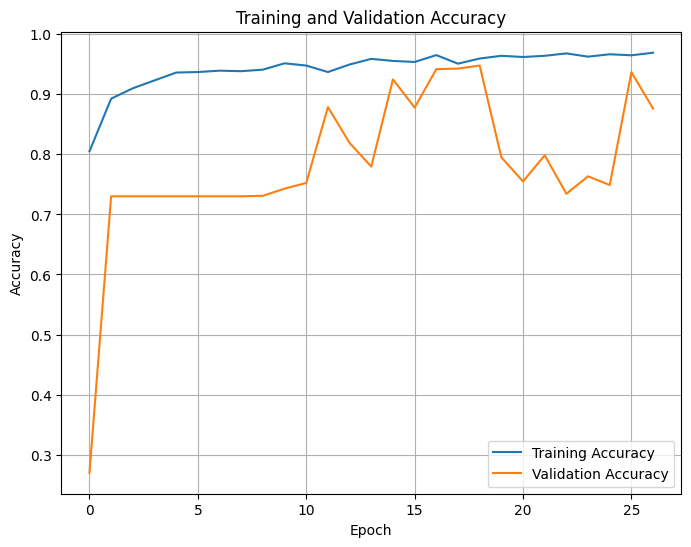

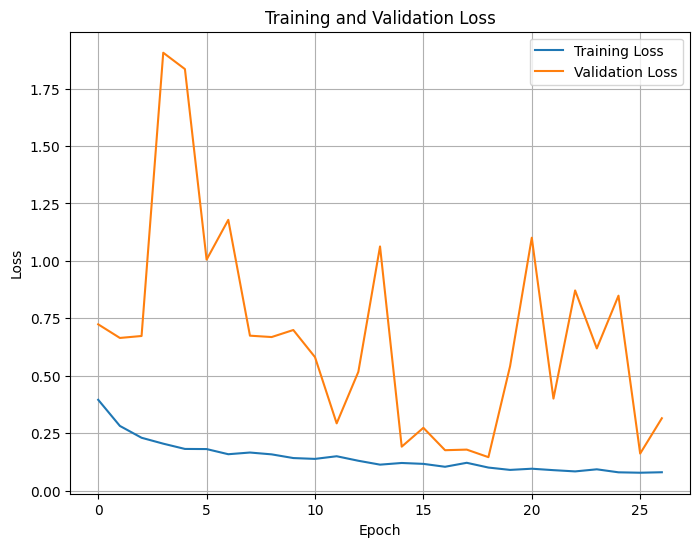

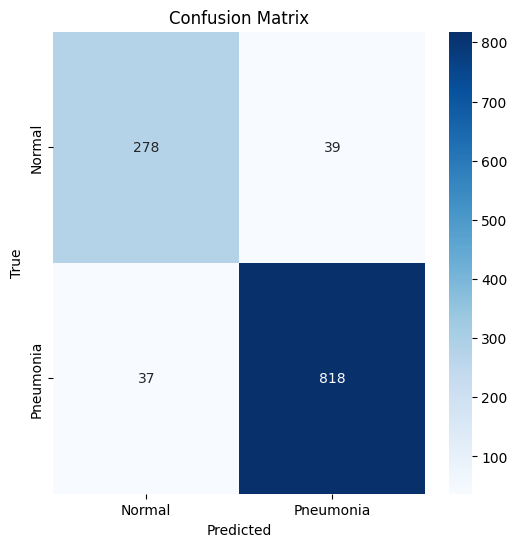

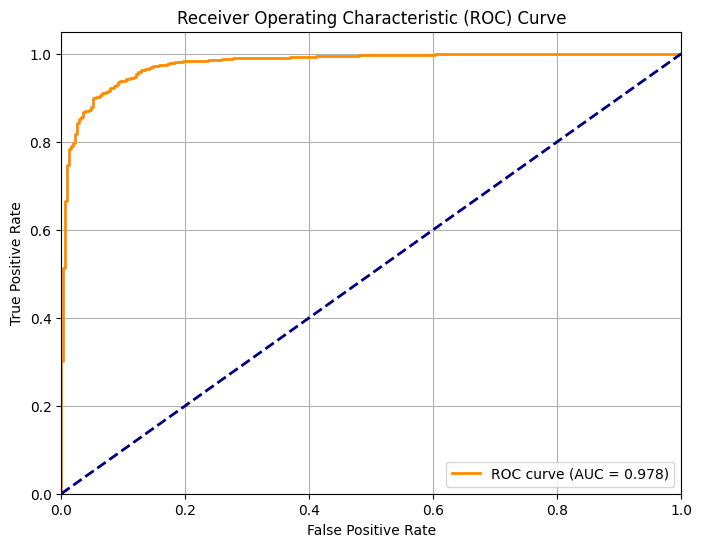

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

# Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_true, test_predictions_binary)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(test_true, test_predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()